In [1]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Voting classifiers

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

- Majority Class Labels (Majority/Hard Voting)
  In majority voting, the predicted class label for a particular sample is the class label that represents the majority (mode) of the class labels predicted by each individual classifier.

    E.g., if the prediction for a given sample is

    classifier 1 -> class 1

    classifier 2 -> class 1

    classifier 3 -> class 2

    the VotingClassifier (with voting='hard') would classify the sample as “class 1” based on the majority class label.

- Weighted Average Probabilities (Soft Voting)
    soft voting returns the class label as argmax of the sum of predicted probabilities. Specific weights can be assigned to each classifier via the weights parameter. When weights are provided, the predicted class probabilities for each classifier are collected, multiplied by the classifier weight, and averaged. The final class label is then derived from the class label with the highest average probability.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [3]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver = 'lbfgs', random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = 'scale', random_state = 42)

#Hard voting:
voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')

In [4]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.model_selection import cross_val_score

for clf, label in zip([log_clf, rnd_clf, svm_clf, voting_clf], ['Logistic Regression', 'Random Forest', 'SVC', 'Ensemble']):
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.84 (+/- 0.03) [Logistic Regression]
Accuracy: 0.89 (+/- 0.02) [Random Forest]
Accuracy: 0.92 (+/- 0.02) [SVC]
Accuracy: 0.91 (+/- 0.01) [Ensemble]


In [6]:
log_clf = LogisticRegression(solver = 'lbfgs', random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = 'scale', probability = True, random_state = 42)

#Soft voting:
voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


### Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms(voting classifiers).
Another approach is to use the **same training algorithm** for every predictor, but to **train them on different random subsets of the training set**. When sampling is performed with replacement, this method is called
**bagging (short for bootstrap aggregating)**. When sampling is performed without replacement, it is called **pasting**.
In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. 
Once all predictors are trained, the ensemble can make a prediction for a new instance by simply **aggregating** the predictions of all predictors. The aggregation function is typically **the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression**. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a
similar bias but a lower variance than a single predictor trained on the original training set.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state = 42), 
    n_estimators = 500, #Number of trees
    max_samples = 100, #trained on 100 training instances randomly sampled from the training set with replacement
    bootstrap = True, # for pasting set bootstrap = False
    random_state = 42 #n_jobs tells the number of CPU core to use, -1 means all available CPUs
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
accuracy_score(y_test, y_pred)

0.904

In [10]:
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.856

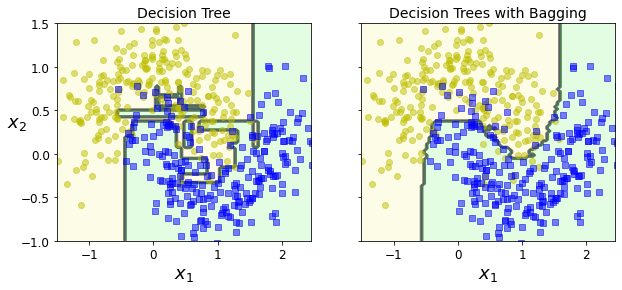

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

The BaggingClassifier class supports sampling the features as well. This is controlled by two hyperparameters: **max_features and bootstrap_features.** They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.
This is particularly useful when you are dealing with **high-dimensional inputs (such as images)**. Sampling both training instances and features is called the Random Patches method. Keeping all training instances
(i.e., bootstrap=False and max_samples=1.0) but sampling features (i.e., bootstrap_features=True and/or max_features smaller than 1.0) is called the Random Subspaces method. Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.


### Random Forests

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', 
                           max_leaf_nodes=16, 
                           random_state=42),
    n_estimators=500, 
    max_samples=1.0, 
    bootstrap=True, 
    random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes = 16,
    random_state = 42)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [14]:
np.sum(y_pred == y_pred_rf)/ len(y_pred) #almost identical predictions

0.976

### Extra-Trees
When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like
regular Decision Trees do).
A forest of such extremely random trees is simply called an Extremely Randomized Trees ensemble12 (or Extra-Trees for short). Once again, this trades more bias for a lower variance. It also makes Extra-Trees
much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.
You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier class. Its API is identical to the  RandomForestClassifier class. Similarly, the ExtraTreesRegressor class has the same API as the RandomForestRegressor class.

### Feature Importance
Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it. Scikit-Learn computes this score automatically for each feature after training, then it scales the results so
that the sum of all importances is equal to 1. You can access the result using the feature_importances_ variable.

In [15]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(
    n_estimators=500,
    random_state = 42)
rnd_clf.fit(iris['data'], iris['target']) 

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [16]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively).

In [17]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(random_state=42)

In [18]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

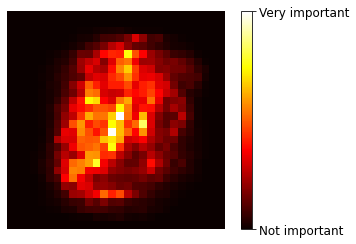

In [19]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

### Out-of-Bag evaluation
By default a BaggingClassifier samples m training instances with replacement
(bootstrap=True), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor.6 The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.
Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.
In Scikit-Learn, by setting "oob_score=True" when creating a BaggingClassifier to request an automatic oob evaluation after training.



In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [21]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

### AdaBoost

To build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.

Scikit-Learn actually uses a multiclass version of AdaBoost called SAMME (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the predictors can estimate class probabilities
(i.e., if they have a predict_proba() method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better. 

The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn’s AdaBoostClassifier class. A Decision Stump is a Decision Tree with max_depth=1 — in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class.
If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator. If it underfits the training data, you can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate.

In [22]:
from sklearn.ensemble import AdaBoostClassifier
# Scikit-Learn uses a multiclass version of AdaBoost called SAMME
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm = 'SAMME.R', learning_rate = 0.5, random_state = 42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

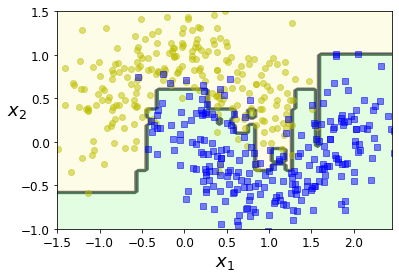

In [23]:
plot_decision_boundary(ada_clf, X, y)


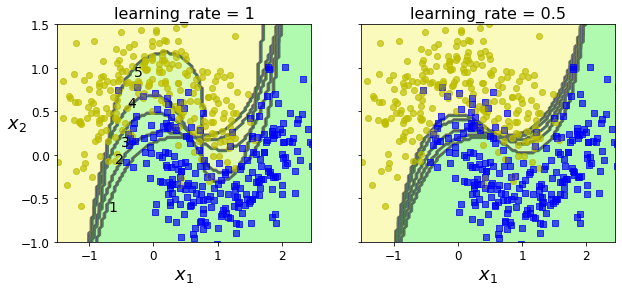

In [24]:
m = len(X_train)
fig, axes = plt.subplots(ncols = 2, figsize = (10, 4), sharey = True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel = 'rbf', C = 0.05, gamma = 'scale',
                      random_state = 42)
        svm_clf.fit(X_train, y_train, sample_weight = sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. The plot on the right represents the same sequence of predictors except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration). As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better. Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

### Gradient Boosting
Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In [25]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [26]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [27]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [28]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [29]:
X_new = np.array([[0.8]])

In [30]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, 
                                             tree_reg3))

In [31]:
y_pred

array([0.75026781])

**Note:** If your Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate. You could also use early stopping to find the right number of predictors (you probably have too many). 
The **learning_rate hyperparameter** scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called shrinkage.

In [32]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, 
                                 n_estimators =3, #The number of boosting stages to perform
                                 learning_rate = 1.0, #shrinks the contribution of each tree by learning_rate
                                 random_state = 42)
gbrt.fit(X, y)                                

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [34]:
gbrt_slow = GradientBoostingRegressor(max_depth = 2,
                                      n_estimators =200, 
                                      learning_rate = 0.1, 
                                      random_state = 42)
gbrt_slow.fit(X, y)  

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

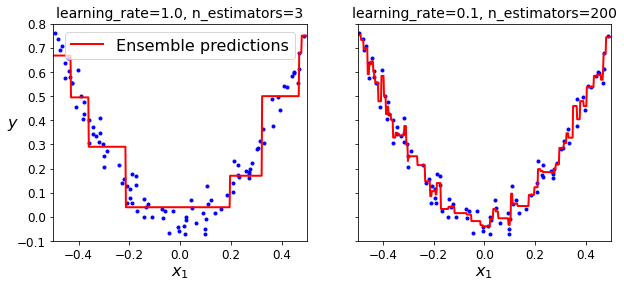

In [35]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)


plt.show()

### Gradient Boosting with Early stopping

In order to find the **optimal number of trees, you can use early stopping**. A simple way to implement this is to use the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a
GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [36]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 49)

gbrt = GradientBoostingRegressor(max_depth = 2,
                                n_estimators = 120,
                                random_state = 42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth = 2,
                                     n_estimators = bst_n_estimators,
                                     random_state = 42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [37]:
min_error = np.min(errors)

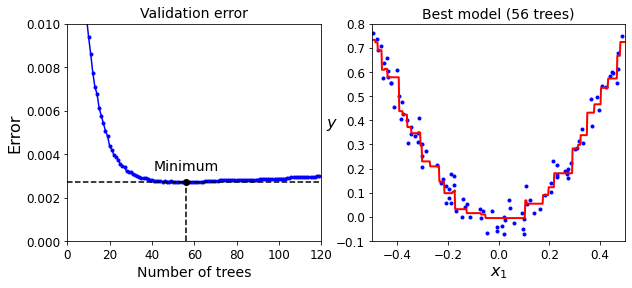

In [38]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting **warm_start=True**, which makes Scikit-Learn keep existing trees when the fit() method is called,
allowing incremental training. The following code stops training when the validation error does not improve for five iterations in a row:

In [39]:
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True,
                                random_state = 42)
min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
    if error_going_up == 5:
        break

In [40]:
print(gbrt.n_estimators)

61


In [41]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


**Notes:**
- If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that’s the whole point of bagging and pasting ensembles), but if not it will still work as long as the models are very different.
- A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set probability=True).
- It is quite possible to speed up training of a bagging ensemble by distributing it across multiple servers, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and you will not gain anything by distributing training across multiple servers. Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained.

### Voting Classifier- MNIST

In [42]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size = 10000, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [44]:
random_forest_clf = RandomForestClassifier(n_estimators = 100, 
                                          random_state = 42)
extra_trees_clf = ExtraTreesClassifier(n_estimators = 100, 
                                       random_state = 42)
svm_clf = LinearSVC(random_state = 42)
mlp_clf = MLPClassifier(random_state = 42)

In [45]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print('Training the: ', estimator)
    estimator.fit(X_train, y_train)

Training the:  RandomForestClassifier(random_state=42)
Training the:  ExtraTreesClassifier(random_state=42)
Training the:  LinearSVC(random_state=42)


C:\Users\mahem\AppData\Local\Continuum\anaconda3\envs\DataSience101\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the:  MLPClassifier(random_state=42)


In [46]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8695, 0.9616]

Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier.

In [47]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

voting_clf = VotingClassifier(named_estimators)

In [48]:
voting_clf.fit(X_train, y_train)

C:\Users\mahem\AppData\Local\Continuum\anaconda3\envs\DataSience101\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', LinearSVC(random_state=42)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [49]:
voting_clf.score(X_val, y_val)

0.9703

In [51]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.8695, 0.9616]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to None using set_params():

In [52]:
voting_clf.set_params(svm_clf = None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [53]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [54]:
#it did not update the list of trained estimators:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(random_state=42),
 MLPClassifier(random_state=42)]

So we can either fit the VotingClassifier again, or just remove the SVM from the list of trained estimators:

In [55]:
del voting_clf.estimators_[2]

In [56]:
voting_clf.score(X_val, y_val)

0.9732

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set voting to "soft":

In [57]:
voting_clf.voting = 'soft'

In [58]:
voting_clf.score(X_val, y_val)

0.9682

Hard voting wins in this case. Once we have found one, try it on the test set.

In [59]:
voting_clf.voting = 'hard'
voting_clf.score(X_test, y_test)

0.971

In [60]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9617]